<a href="https://colab.research.google.com/github/deexth/Pyt/blob/master/chpt2_hml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Install and import the libraries/dependencies


In [1]:
%pip install pandas matplotlib numpy pathlib
%pip install -U scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import pathlib
from zlib import crc32
import matplotlib.pyplot as plt
import tarfile
import urllib.request
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
)
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
    make_column_selector,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, expon, loguniform
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin, MetaEstimatorMixin, clone
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import set_config
from scipy import stats
import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.estimator_checks import check_estimator

set_config(display="diagram")  # Makes the pipelines interactive diagrms

%matplotlib inline

# Get the data


_We are going to predict the median house value of in the californian district_


## Download the data


In [3]:
def load_housing_data(url):
    tarball_path = pathlib.Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
        url = url
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(pathlib.Path("datasets/housing/housing.csv"))


url = "https://github.com/ageron/data/raw/main/housing.tgz"
housing = load_housing_data(url)


## Take a quick look at the data structure


In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing["median_income"].max()

15.0001

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing[["ocean_proximity"]].value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300) -> None:
    path = pathlib.Path("datasets/Images/end_to_end_project")
    if not path.is_dir():
        path.mkdir(parents=True, exist_ok=True)

    path_with_file = path / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path_with_file, format=fig_extension, dpi=resolution)
    print(f"Saving figure {fig_id}")

Saving figure attribute_histogram_plots


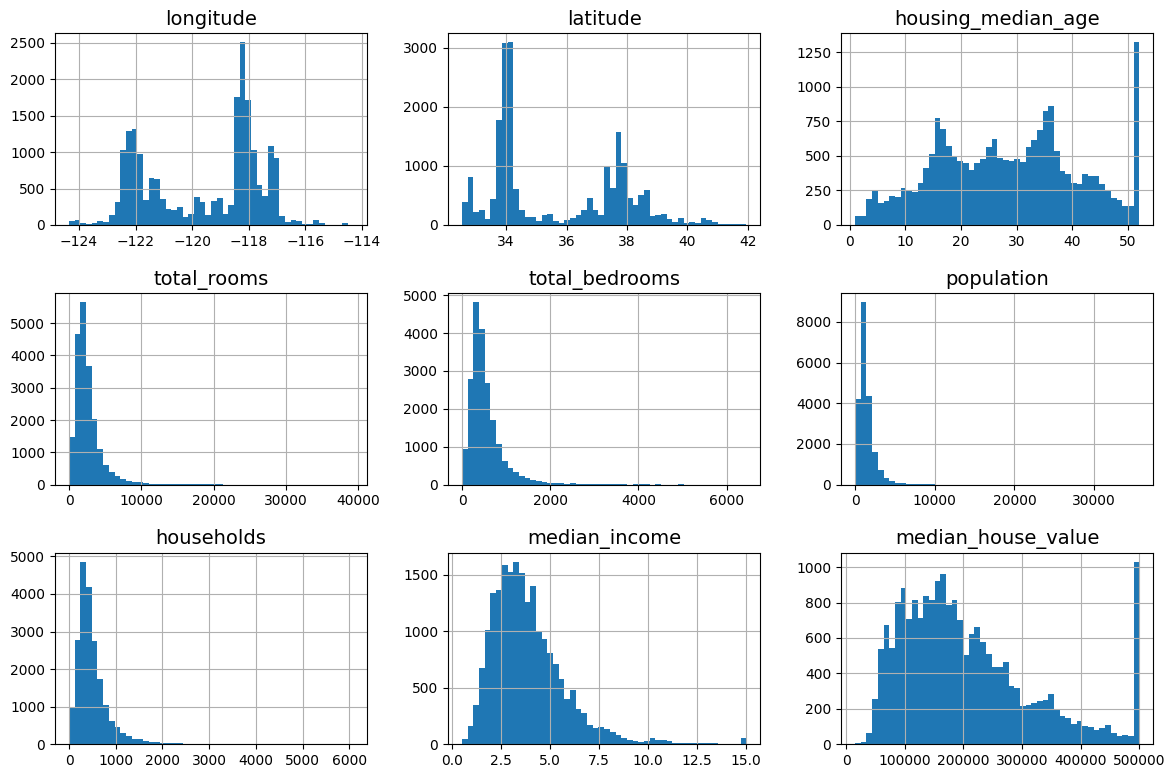

In [10]:
# extra code – the next 5 lines define the default font sizes
plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()

# Create a test


In [11]:
housing["median_income"].min()

0.4999

In [12]:
def shuffle_and_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[test_indices], data.iloc[train_indices]


test_set, train_set = shuffle_and_split(housing, 0.2)
len(test_set), len(train_set)

(4128, 16512)

_To always get the same data in the future or when there's new data we can set a random seed **np.random.seed(42)**, or we can use a hash to add 20% of values less than the has value to the test set and the rest to the train st_


In [13]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier).tobytes()) < test_ratio * 2**32


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
len(test_set), len(train_set)

(4128, 16512)

In [14]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
housing["median_income"].value_counts()


median_income
3.1250     49
15.0001    49
2.8750     46
4.1250     44
2.6250     44
           ..
4.2670      1
2.1217      1
4.9706      1
3.4450      1
2.0943      1
Name: count, Length: 12928, dtype: int64

_We can try using the longitude and latitude as the identifiers since they are bound to not change anyttime soon, and it prevents some data being mixed up in case new data is not appended at the end or an ID is deleted._


In [16]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")
len(test_set), len(train_set)

(4318, 16322)

In [17]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(test_set), len(train_set)

(4128, 16512)

### Stratified sampling


_Dividing the median income into categories labeled 1 to 5 where 1 is ranges of 0-1.5, so less than $15k amount income_


Saving figure income_cat_bar_plot


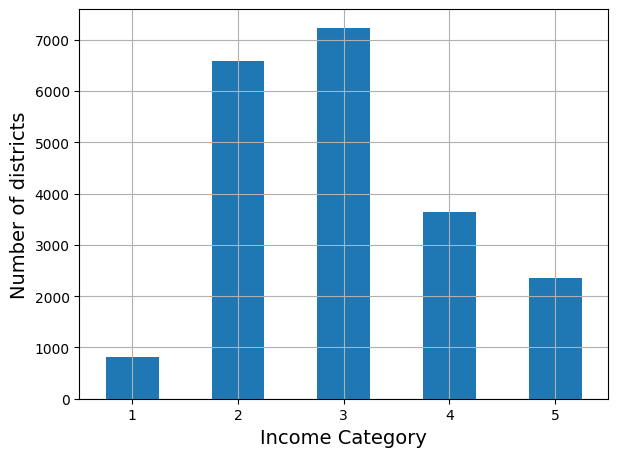

In [ ]:
housing["income_cat"] = pd.cut(
    housing["median_income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5]
)
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
save_fig("income_cat_bar_plot")
plt.show()

_Using sk-learn for stratified sampling_


In [19]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]
    strat_splits.append([strat_train_set, strat_test_set])

strat_train_set, strat_test_set = strat_splits[0]


_If we wanted a single split with stratified sampling we can use the train_test_split function and pass is stratified_


In [20]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

_check the income category proportions in the test set_


In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

_Compare the data generated using stratified sampling and randomness_


In [22]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_df = pd.DataFrame(
    {
        "Overall %": income_cat_proportions(housing),
        "Stratified %": income_cat_proportions(strat_test_set),
        "Random %": income_cat_proportions(test_set),
    }
).sort_index()

compare_df.index.name = "Income Category"

compare_df["strat error %"] = compare_df["Stratified %"] / compare_df["Overall %"] - 1
compare_df["random error %"] = compare_df["Random %"] / compare_df["Overall %"] - 1
(100 * compare_df).round(2)

,Overall %,Stratified %,Random %,strat error %,random error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


_Since we no longer need the income_cat column we can drop it_


In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Explore and visualize the data to get insights


### _Function to get images_


In [24]:
def get_image(url, filename, extension="png"):
    path = pathlib.Path("datasets/Images/")
    if not path.is_dir():
        path.mkdir(parents=True, exist_ok=True)

    full_path = path / f"{filename}.{extension}"
    urllib.request.urlretrieve(url, full_path)
    return full_path


### _Make a copy of the training set before making the exploration_


In [25]:
housing = strat_train_set.copy()

## Visualizing geographical data


Saving figure bad_visualization_plot


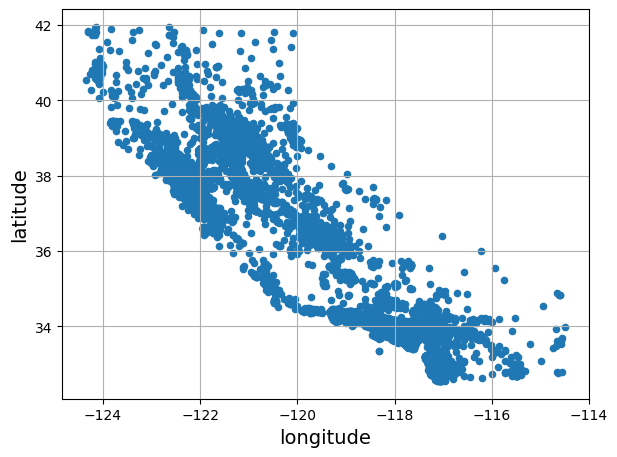

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

_Use alpha to have a better visualization_


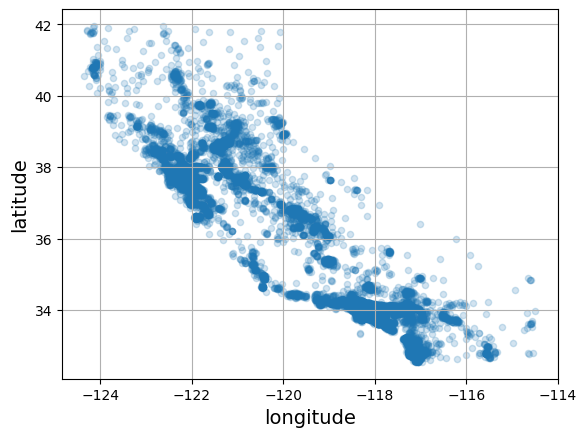

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, grid=True)
plt.show()

_Add heatmap to the plot_


Saving figure housing_prices_scatter_plot


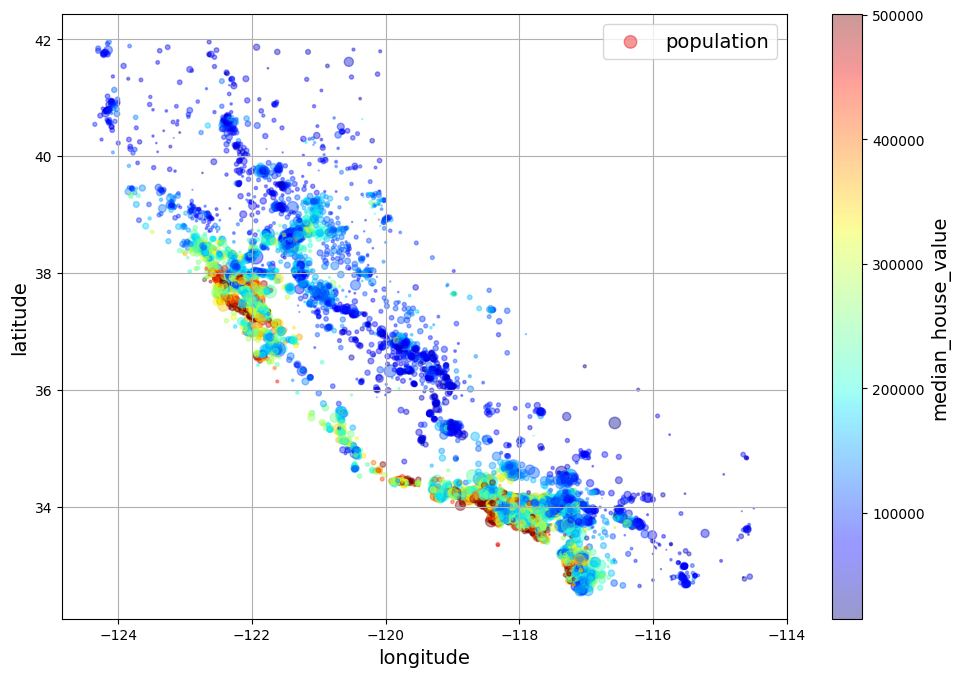

In [28]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"] / 100,
    label="population",
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    grid=True,
    legend=True,
    sharex=False,
)
save_fig("housing_prices_scatter_plot")
plt.show()

_Plot over the california map_


Saving figure california_housing_prices_plot


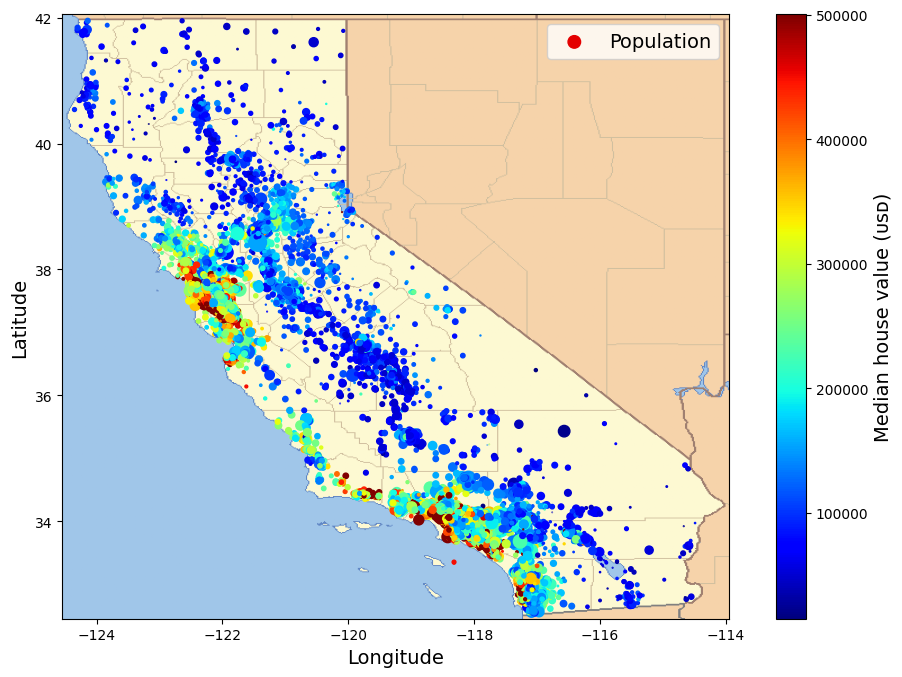

In [29]:
housing_renamed = housing.rename(
    columns={
        "latitude": "Latitude",
        "longitude": "Longitude",
        "population": "Population",
        "median_house_value": "Median house value (ᴜsᴅ)",
    }
)
housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Median house value (ᴜsᴅ)",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)

url = "https://github.com/ageron/handson-ml3/raw/main/images/end_to_end_project/california.png"
get_image(url, "california")

path = pathlib.Path("datasets/Images/california.png")
california_img = plt.imread(path)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

### Look for correlations


In [30]:
coor_matrix = housing.corr(numeric_only=True)
coor_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


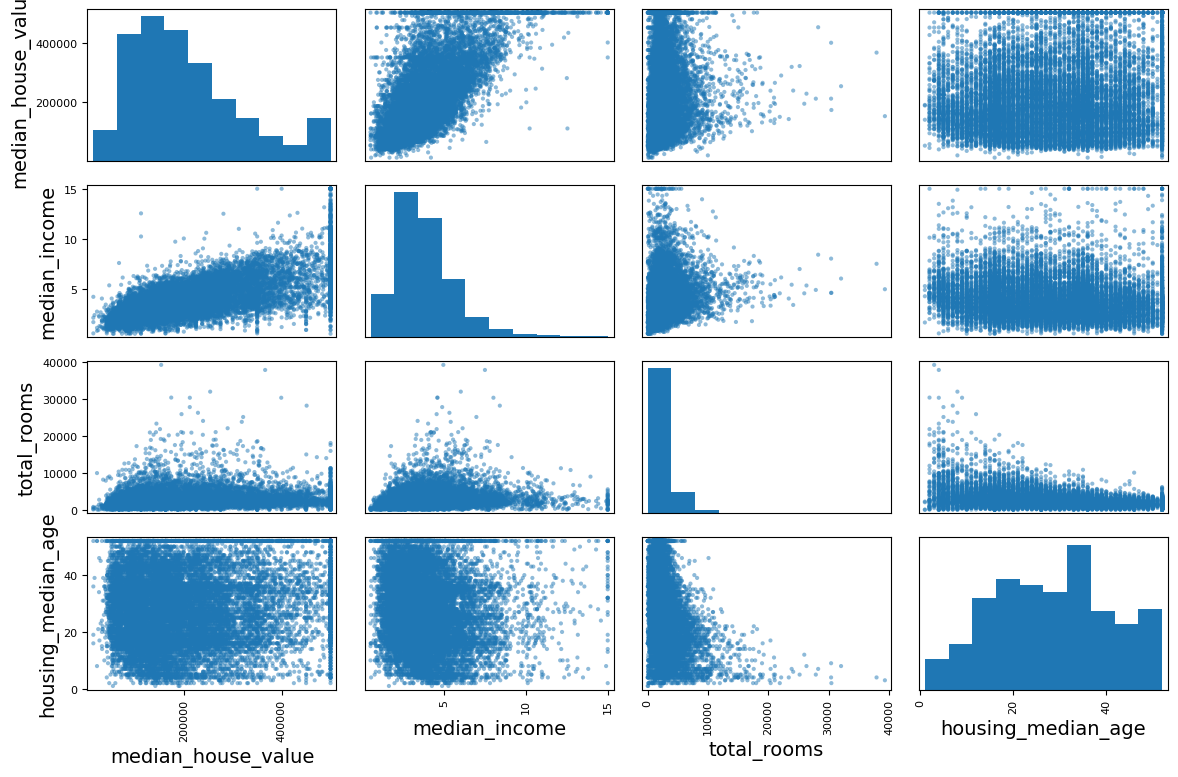

In [31]:
attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age",
]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()

Saving figure income_vs_house_value_scatter_plot


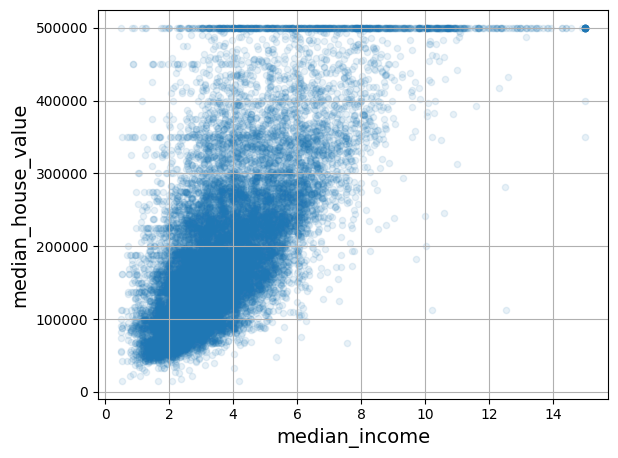

In [32]:
housing.plot(
    kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True
)
save_fig("income_vs_house_value_scatter_plot")
plt.show()

## Experimenting with attribute combinations


In [33]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [34]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_ratio             -0.256397
Name: median_house_value, dtype: float64

# Prepare the data for machine learning algorithms


_Separate the labels and predictors from the strat_train_set_


In [35]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Clean the data


In [36]:
imputer = SimpleImputer(strategy="median")

_Separate numerical values to apply the "median", since it cannot be applied on non-numerical values_


In [37]:
housing_num = housing.select_dtypes(include=[np.number])

In [38]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [39]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

_Check if it is similar to the manually computed median for each value_


In [40]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

_Transform the training set_


In [41]:
X = imputer.transform(housing_num)

In [42]:
imputer.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [43]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

_Wrap a DF arround the output of transform as it output a numpy array_


In [44]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

_Check if the null are no longer in our data_


In [45]:
null_rows_idx = housing.isnull().any(axis=1)
housing_tr[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


## Handling text and categorical attributes


_Preporcessing `"Ocean_proximity"`_


In [46]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


_Let's now process the categorical attributes of `"Ocean proximity"`_


In [47]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [48]:
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [49]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [50]:
one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)

_Since the OneHotEncoder outputs a sparse array we can use `toarray()`, to have it changed to a np array. Alternatively the parameter `sparse_output=False` can be passed to the `OneHotEncoder`_


In [51]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [52]:
housing_cat_1hot_df = pd.DataFrame(
    housing_cat_1hot.toarray(),
    columns=one_hot_encoder.categories_,
    index=housing_cat.index,
)
housing_cat_1hot_df

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
14207,1.0,0.0,0.0,0.0,0.0
13105,0.0,1.0,0.0,0.0,0.0
19301,0.0,0.0,0.0,0.0,1.0
19121,1.0,0.0,0.0,0.0,0.0


In [53]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [54]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test, dtype=int)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


In [55]:
one_hot_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

_By visualizing the columns for `get_dummies()` and `OneHoEncoder` we see that `get_dummies()` only accounts for the 2 columns given to it, whereas `OneHotEncoder` output a column for every category learnt in the right order after being passed the df_test_


In [56]:
df_test_encoded = pd.DataFrame(
    one_hot_encoder.transform(df_test).toarray(),
    columns=one_hot_encoder.get_feature_names_out(),
    index=df_test.index,
)
df_test_encoded

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0


_If `get_dummies()` is passed a unkown category it will happily generate a column, but `OneHotEncoder` is smarter and will complain. Unless `ignore` is passed to it, then in this case it will output zeros for the unknown category_


In [57]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown, dtype=int)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


In [58]:
one_hot_encoder.handle_unknown = "ignore"
one_hot_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [59]:
one_hot_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [60]:
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [61]:
one_hot_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [62]:
df_output = pd.DataFrame(
    one_hot_encoder.transform(df_test_unknown).toarray(),
    columns=one_hot_encoder.get_feature_names_out(),
    index=df_test_unknown.index,
)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


## Feature scaling and transformation


In [63]:
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaler = min_max_scaler.fit_transform(housing_num)

In [64]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


In [65]:
housing_num_min_max_scaler_df = pd.DataFrame(
    housing_num_min_max_scaler,
    columns=min_max_scaler.feature_names_in_,
    index=housing_num.index,
)
housing_num_min_max_scaler_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
14973,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
3785,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369
14689,0.468560,-0.744681,-0.372549,-0.787782,-0.726204,-0.774015,-0.709166,-0.756983
20507,0.257606,-0.740426,0.372549,-0.778015,-0.610243,-0.765796,-0.562815,-0.582171


In [66]:
standard_scaler = StandardScaler()
housing_num_standard_scaler = standard_scaler.fit_transform(housing_num)

In [67]:
housing_num_standard_scaler_df = pd.DataFrame(
    housing_num_standard_scaler,
    columns=standard_scaler.feature_names_in_,
    index=housing_num.index,
)
housing_num_standard_scaler_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.736231,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.585590,0.444376,1.755263,-0.180365


_Plotting to visualize the long-tail in the population column and scalling it using the it's log_


Saving figure long_tail_plot


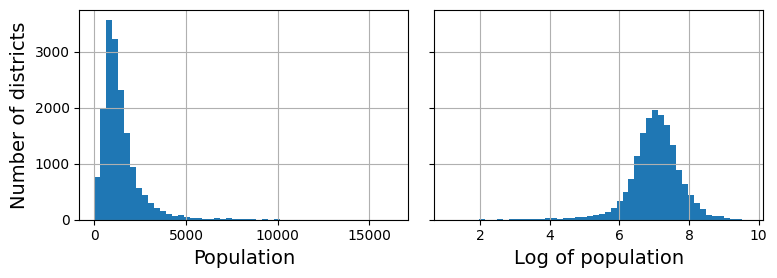

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

_Plotting by changing with it's percentile instead_


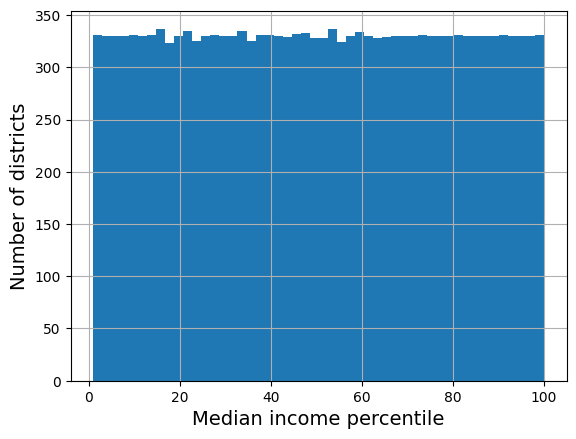

In [69]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]
flattened_median_income = pd.cut(
    housing["median_income"],
    bins=[-np.inf] + percentiles + [np.inf],
    labels=range(1, 100 + 1),
)
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).

In [70]:
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
# age_simil_35

Saving figure age_similarity_plot


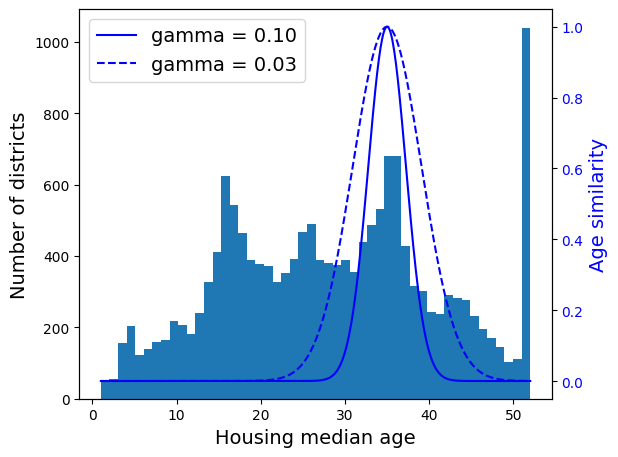

In [71]:
# extra code – this cell generates Figure 2–18

ages = np.linspace(
    housing["housing_median_age"].min(), housing["housing_median_age"].max(), 500
).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()

In [72]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_neW_data = housing[["median_income"]].iloc[:5]  # pretending this is some new data

scaled_prediction = model.predict(some_neW_data)
predictions = target_scaler.inverse_transform(scaled_prediction)

In [73]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [74]:
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)

predictions = model.predict(some_neW_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers


_To create simple transformation. For tranformers that do not require training we can write a function that takes array input and ouput a transformed array:_


In [75]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [76]:
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


In [77]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [78]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

_Using the above custome transformer to measure the similarity between distances for the SF districts._


In [79]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))

sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [80]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

_Using the custom transformer to measure similarity between 2 points_


In [81]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1.0, 2.0], [3.0, 4.0]]))

array([[0.5 ],
       [0.75]])

_If we want to train our transfomrer we can create a custom class with **fit()** and **transform()**. The below class example is basically a clone of the **STandardScaler()** function_


In [82]:
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args and **Kwards
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though it is not used
        X = check_array(X)  # Checks if X has a finite number of float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # Every estimator stores this in fit()
        return self  # always return self

    def transform(self, X):
        check_is_fitted(self)  # check for learned patterns with trailing (__)
        X = X.check_array(X)
        assert self.n_features_in_ == X.shape[1]

        if self.with_mean:
            X = X - self.with_mean_

        return X / X.shape_

Custom transformers can use other estimators in there **fit()** method. For example the below uses the **kmeans clusterer** to identify the main clusters in the training and then uses the **rbf_kernal** to measure the similarity in the **transform method**


In [83]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(
            self.n_clusters, n_init=10, random_state=self.random_state
        )
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # Always return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


**Warning**:

- There was a change in Scikit-Learn 1.3.0 which affected the random number generator for `KMeans` initialization. Therefore the results will be different than in the book if you use Scikit-Learn ≥ 1.3. That's not a problem as long as you don't expect the outputs to be perfectly identical.
- Throughout this notebook, when `n_init` was not set when creating a `KMeans` estimator, I explicitly set it to `n_init=10` to avoid a warning about the fact that the default value for this hyperparameter will change from 10 to `"auto"` in Scikit-Learn 1.4.


_Let's try out thecustome transformer now_


In [84]:
similarity_cluster = ClusterSimilarity(n_clusters=10, gamma=1, random_state=42)
similarities = similarity_cluster.fit_transform(
    housing[["latitude", "longitude"]], sample_weight=housing_labels
)

In [85]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

Saving figure district_cluster_plot


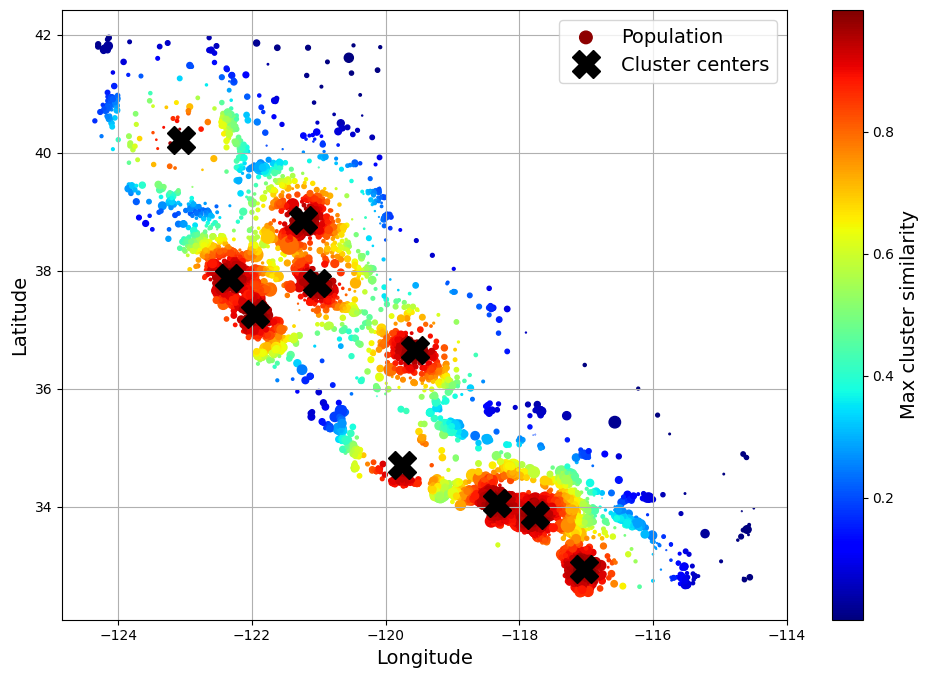

In [86]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(
    columns={
        "latitude": "Latitude",
        "longitude": "Longitude",
        "population": "Population",
        "median_house_value": "Median house value (ᴜsᴅ)",
    }
)
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    grid=True,
    s=housing_renamed["Population"] / 100,
    label="Population",
    c="Max cluster similarity",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)
plt.plot(
    similarity_cluster.kmeans_.cluster_centers_[:, 1],
    similarity_cluster.kmeans_.cluster_centers_[:, 0],
    linestyle="",
    color="black",
    marker="X",
    markersize=20,
    label="Cluster centers",
)
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

In [87]:
housing_renamed.head()

,Longitude,Latitude,housing_median_age,total_rooms,total_bedrooms,Population,households,median_income,ocean_proximity,Max cluster similarity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,0.986669
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,0.990046
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,0.699839
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,0.641865
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,0.893456


## Transformation Pipelines


_Now we will build a pipeline to preprocess the numerical attributes_


In [88]:
num_pipeline = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("standarsize", StandardScaler()),
    ]
)

In [89]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standarsize', StandardScaler())])

_If we don't want to name the estimators in the pipeline, we can use the **make_pipeline** class mported from scikit. It will name the estimators for us_


In [90]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [91]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:3].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17],
       [-1.2 ,  1.28,  0.35, -0.71, -0.76, -0.79, -0.78, -0.76]])

In [92]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values())
            + [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


monkey_patch_get_signature_names_out()

In [93]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared,
    columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index,
)

In [94]:
df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


In [95]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [96]:
num_pipeline[1]

StandardScaler()

In [97]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [98]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [99]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

_We can use **ColumnTransformer** class to combine both pipelines. The first for the numerical attributes and the other for the categorical attributes_


In [100]:
num_attribs = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ]
)

_If we don't care about naming the transformer like what we similarly did with **make_pipeline**. We can use the **make_column_transformer** class._
_And use the **make_column_selector** class to automatically select the features of a given types_


In [101]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [102]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

In [103]:
housing_prepared_df = pd.DataFrame(
    housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index
)
housing_prepared_df.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


In [104]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]


def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler(),
    )


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler(),
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocessing = ColumnTransformer(
    [
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        (
            "log",
            log_pipeline,
            [
                "total_bedrooms",
                "total_rooms",
                "population",
                "households",
                "median_income",
            ],
        ),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline,
)  # one column remaining: housing_median_age

In [105]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [106]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Select and train a model


Ready to select and train a model


## Train and evaluate on the training set


In [107]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x0000010D3B3434C0>,
                                                                      func=<function column_r...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000010D3AE25590>)])

In [108]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)
housing_predictions = lin_reg.predict(housing)

Now let's compare the five first predictions to the labels.


In [109]:
housing_predictions[:5].round(-2)  # rounded to the nearest hundreth

array([242800., 375900., 127500.,  99400., 324600.])

In [110]:
housing_labels.iloc[:5].values  # or housing_labels[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [111]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-47.0%, -22.3%, 25.4%, 3.4%, -10.3%


Let's measure the models RSME using the mean_square_root. We set squared to False to not square the error value


In [112]:
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68647.95686706669

As we can see we are way off.Let's try a more powerfull model.


In [113]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)
housing_predictions = tree_reg.predict(housing)

Let's now evaluate the mean squred error for this model.


In [114]:
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

0.0

0! THis is an example of a model overfitting.


## Better validation using cross-validation


Let's use the cross_val_score function to split the trainin set into 10 smaller training sets the descision tree can randonmly evaluate over.


In [115]:
tree_rsmes = -cross_val_score(
    tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10
)

In [116]:
tree_rsmes

array([66343.67404108, 63925.25310602, 66874.84912025, 66716.81062178,
       65930.10085465, 70664.63583294, 66933.74083972, 68454.11092405,
       69693.52916464, 65996.47822622])

In [117]:
pd.Series(tree_rsmes)

0    66343.674041
1    63925.253106
2    66874.849120
3    66716.810622
4    65930.100855
5    70664.635833
6    66933.740840
7    68454.110924
8    69693.529165
9    65996.478226
dtype: float64

In [118]:
pd.Series(tree_rsmes).describe()

count       10.000000
mean     67153.318273
std       1963.580924
min      63925.253106
25%      66083.277180
50%      66795.829871
75%      68074.018403
max      70664.635833
dtype: float64

Let's try a random forest model and see if it works any better


In [119]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rsems = -cross_val_score(
    forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10
)

In [120]:
pd.Series(forest_rsems).describe()

count       10.000000
mean     47002.931706
std       1048.451340
min      45667.064036
25%      46494.358345
50%      47093.173938
75%      47274.873814
max      49354.705514
dtype: float64

The random forest looks to be doing better, but if we check it's RSME we find that it says a different thing. Tere's still quite a bit of overfitting, atleast now we know which model out of the three performs better and can build from this.


In [121]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rsem = root_mean_squared_error(housing_labels, housing_predictions)
forest_rsem

17547.52124624957

Let's see what the linear regression cross val would be too.


In [122]:
lin_rsems = -cross_val_score(
    lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10
)
pd.Series(lin_rsems).describe()

count       10.000000
mean     69847.923224
std       4078.407329
min      65659.761079
25%      68088.799156
50%      68697.591463
75%      69800.966364
max      80685.254832
dtype: float64

# Fine tune a model


Fine-tune promising models


## Grid search


Warning: the following cell may take a few minutes to run:


In [123]:
full_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("random_forest", RandomForestRegressor(random_state=42)),
    ]
)
param_grid = [
    {
        "preprocessing__geo__n_clusters": [5, 8, 10],
        "random_forest__max_features": [4, 6, 8],
    },
    {
        "preprocessing__geo__n_clusters": [10, 15],
        "random_forest__max_features": [6, 8, 10],
    },
]
grid_search = GridSearchCV(
    full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error"
)
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000010D3AE25590>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

You can get the full list of hyperparameters available for tuning by looking at full_pipeline.get_params().keys():


In [124]:
# extra code – shows part of the output of get_params().keys()
print(str(full_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'random_forest', 'preprocessing__force_int_remainder_cols', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'prepro

The best hyperparameter combination found:


In [125]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [126]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000010...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000010D3C8FB7D0>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

Let's look at the score of each hyperparameter combination tested during the grid search:


In [127]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[
    [
        "param_preprocessing__geo__n_clusters",
        "param_random_forest__max_features",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "mean_test_score",
    ]
]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43536,43753,44569,43953
13,15,8,44084,44205,44863,44384
14,15,10,44368,44496,45200,44688
7,10,6,44251,44628,45857,44912
9,10,6,44251,44628,45857,44912


## Randomized Search


Try 30 (`n_iter` × `cv`) random combinations of hyperparameters:


Warning: the following cell may take a few minutes to run:


In [128]:
param_distribs = {
    "preprocessing__geo__n_clusters": randint(low=3, high=50),
    "random_forest__max_features": randint(low=2, high=20),
}

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42,
)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000010D3AE419D0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000010D3AE40D50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [129]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[
    [
        "param_preprocessing__geo__n_clusters",
        "param_random_forest__max_features",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "mean_test_score",
    ]
]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41115,42151,42695,41987
8,32,7,41604,42200,43219,42341
0,41,16,42106,42743,43443,42764
5,42,4,41812,42925,43557,42765
2,23,8,42421,43094,43856,43124


**Bonus section: how to choose the sampling distribution for a hyperparameter**

- `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
- `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
- `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
- `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
- `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.


Here are plots of the probability mass functions (for discrete variables), and probability density functions (for continuous variables) for `randint()`, `uniform()`, `geom()` and `expon()`:


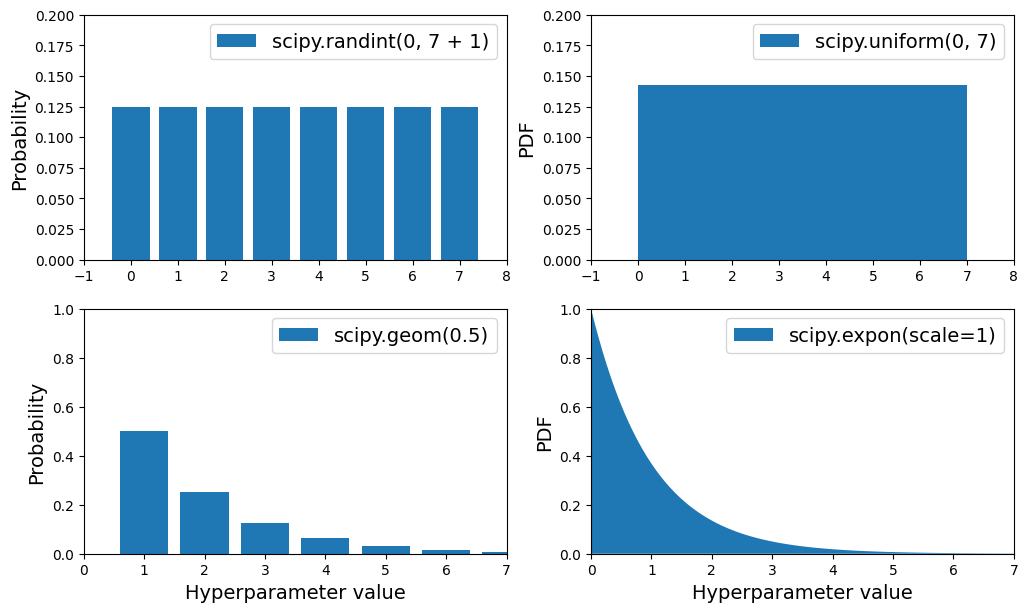

In [130]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `loguniform()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `loguniform()` does not favor any scale, they are all equally likely:


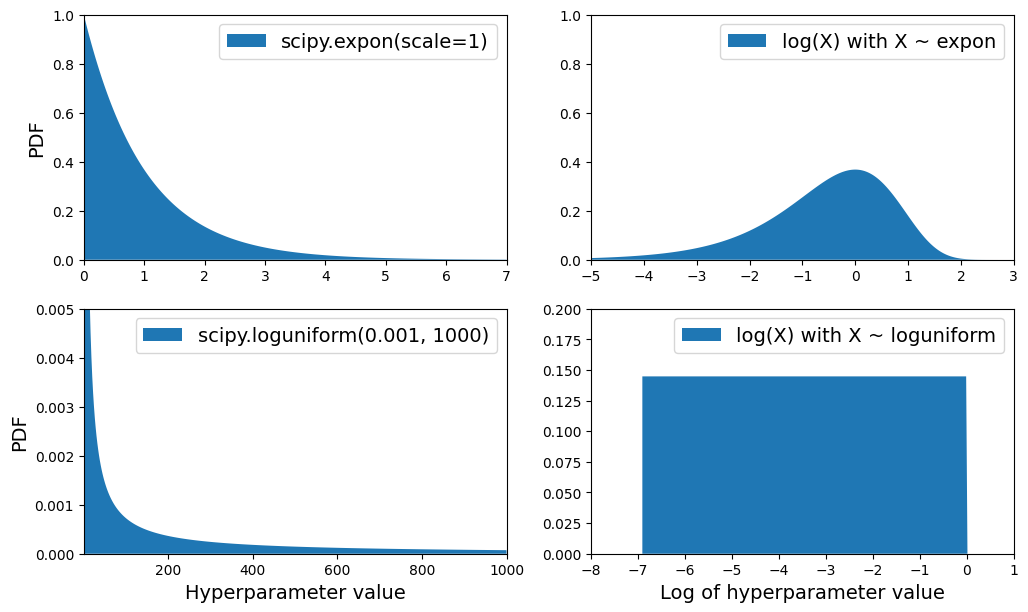

In [131]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib, label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib, label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib, label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib, label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analyze the Best Models and Their Errors


In [132]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [133]:
sorted(
    zip(feature_importances, final_model["preprocessing"].get_feature_names_out()),
    reverse=True,
)

[(0.1898423270105783, 'log__median_income'),
 (0.07709175866873944, 'cat__ocean_proximity_INLAND'),
 (0.06455488601956336, 'bedrooms__ratio'),
 (0.056936146643377976, 'rooms_per_house__ratio'),
 (0.0490294770805355, 'people_per_house__ratio'),
 (0.03807069074492323, 'geo__Cluster 3 similarity'),
 (0.025643913400094472, 'geo__Cluster 22 similarity'),
 (0.02179127543243723, 'geo__Cluster 17 similarity'),
 (0.021575251507503695, 'geo__Cluster 6 similarity'),
 (0.017868654556924362, 'geo__Cluster 2 similarity'),
 (0.017431400050755975, 'geo__Cluster 32 similarity'),
 (0.015981159400591683, 'geo__Cluster 18 similarity'),
 (0.014888464257396877, 'geo__Cluster 40 similarity'),
 (0.014488389218107146, 'geo__Cluster 43 similarity'),
 (0.014252940099964142, 'geo__Cluster 7 similarity'),
 (0.014038173319370725, 'geo__Cluster 21 similarity'),
 (0.013846025114732161, 'geo__Cluster 38 similarity'),
 (0.013625709964722737, 'geo__Cluster 34 similarity'),
 (0.013547297167034428, 'geo__Cluster 41 simila

## Evaluate Your System on the Test Set


In [134]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41549.20158097943


We can compute a 95% confidence interval for the test RMSE:


In [135]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors),
    )
)

array([39395.35475927, 43596.76969025])

We could compute the interval manually like this:


In [136]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39395.35475926931, 43596.76969025394)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:


In [137]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39396.00369767951, 43596.18328117898)

## Model persistence using joblib


Save the final model:


In [138]:
joblib.dump(final_model, "models/my_california_housing_model.pkl")

['models/my_california_housing_model.pkl']

Now you can deploy this model to production. For example, the following code could be a script that would run in production:


In [139]:
# extra code – excluded for conciseness
# def column_ratio(X):
#     return X[:, [0]] / X[:, [1]]

# class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("models/my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [140]:
pd.Series(predictions)

0    439808.14
1    455211.06
2    109492.00
3     98208.00
4    340021.04
dtype: float64

In [141]:
housing_labels.iloc[:5]

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

You could use pickle instead, but joblib is more efficient.


# Exercise solutions


## 1.


Exercise: _Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Note that SVMs don't scale well to large datasets, so you should probably train your model on just the first 5,000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now (see the SVM notebook if you're interested). How does the best `SVR` predictor perform?_


In [142]:
# Training on the first 5000 instances with kernel=linear
param_grid = [
    {
        "SVR__kernel": ["rbf"],
        "SVR__gamma": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
        "SVR__C": [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
    },
    {
        "SVR__kernel": ["linear"],
        "SVR__C": [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0],
    },
]


svr = Pipeline([("preprocessing", preprocessing), ("SVR", SVR())])
grid_svr_search = GridSearchCV(
    svr, param_grid, cv=3, scoring="neg_root_mean_squared_error"
)
grid_svr_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000010D3AE25590>)])),
                                       ('SVR', SVR())]),
             param_grid=[{'SVR__C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                     1000.0],
                          'SVR__gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'SVR__kernel': ['rbf']},
                         {'SVR__C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                     10000.0, 30000.0],
                          'SVR__kernel': ['linear']}],
             scoring='neg_root_mean_squared_error')

In [143]:
grid_svr_search.best_estimator_, grid_svr_search.best_params_

(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                               SimpleImputer(strategy='median')),
                                                              ('standardscaler',
                                                               StandardScaler())]),
                                    transformers=[('bedrooms',
                                                   Pipeline(steps=[('simpleimputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('functiontransformer',
                                                                    FunctionTransformer(feature_names_out=<function ratio_name at 0x0000010...
                                                    'median_income']),
                                                  ('geo',
        

In [144]:
svr_cv_res = pd.DataFrame(grid_svr_search.cv_results_)
svr_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
svr_cv_res = svr_cv_res[
    [
        "param_SVR__C",
        "param_SVR__kernel",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "mean_test_score",
    ]
]
score_cols = ["split0", "split1", "split2", "mean_test_rsme"]
svr_cv_res.columns = ["SVR__C", "SVR__kernel"] + score_cols
svr_cv_res[score_cols] = -svr_cv_res[score_cols].round().astype(np.int64)

svr_cv_res.head()


,SVR__C,SVR__kernel,split0,split1,split2,mean_test_rsme
48,10000.0,linear,73099,70529,66227,69951
49,30000.0,linear,75260,69339,65469,70022
47,3000.0,linear,72815,71895,68030,70913
46,1000.0,linear,73971,73578,69609,72386
45,300.0,linear,76027,76041,72017,74695


In [145]:
def model_search_table(search_model, cv_res_param, cv_score_cols):
    cv_res = pd.DataFrame(search_model.cv_results_)
    cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
    cv_res = cv_res[cv_res_param]
    cv_res.columns = [_ for _ in search_model.best_params_.keys()] + cv_score_cols
    cv_res[cv_score_cols] = -cv_res[cv_score_cols].round().astype(np.int64)
    return cv_res.head()


In [146]:
cv_res_param = [
    "param_SVR__C",
    "param_SVR__kernel",
    "split0_test_score",
    "split1_test_score",
    "split2_test_score",
    "mean_test_score",
]
model_search_table(grid_svr_search, cv_res_param, score_cols)

,SVR__C,SVR__kernel,split0,split1,split2,mean_test_rsme
48,10000.0,linear,73099,70529,66227,69951
49,30000.0,linear,75260,69339,65469,70022
47,3000.0,linear,72815,71895,68030,70913
46,1000.0,linear,73971,73578,69609,72386
45,300.0,linear,76027,76041,72017,74695


That's much worse than the `RandomForestRegressor` (but to be fair, we trained the model on much less data). Let's check the best hyperparameters found:


The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.


## 2.


Exercise: _Try replacing the `GridSearchCV` with a `RandomizedSearchCV`._


**Warning:** the following cell will take several minutes to run. You can specify `verbose=2` when creating the `RandomizedSearchCV` if you want to see the training details.


In [147]:
param_distribs = {
    "SVR__C": loguniform(20, 200_000),
    "SVR__gamma": expon(scale=1.0),
    "SVR__kernel": ["linear", "rbf"],
}

svr_rnd_search = RandomizedSearchCV(
    svr,
    param_distributions=param_distribs,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_iter=50,
    random_state=42,
)
svr_rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000010D3AE25590>)])),
                                             ('SVR', SVR())]),
                   n_iter=50,
                   param_distributions={'SVR__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000010D37212450>,
                                        'SVR__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000010D37210F90>,
                                        'SVR__kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [148]:
svr_rnd_search.best_estimator_, svr_rnd_search.best_score_, svr_rnd_search.best_params_

(Pipeline(steps=[('preprocessing',
                  ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                               SimpleImputer(strategy='median')),
                                                              ('standardscaler',
                                                               StandardScaler())]),
                                    transformers=[('bedrooms',
                                                   Pipeline(steps=[('simpleimputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('functiontransformer',
                                                                    FunctionTransformer(feature_names_out=<function ratio_name at 0x0000010...
                                                   ClusterSimilarity(random_state=42),
                                                  

In [149]:
rnd_param = [
    "param_SVR__C",
    "param_SVR__gamma",
    "param_SVR__kernel",
    "split0_test_score",
    "split1_test_score",
    "split2_test_score",
    "mean_test_score",
]
model_search_table(svr_rnd_search, rnd_param, score_cols)

,SVR__C,SVR__gamma,SVR__kernel,split0,split1,split2,mean_test_rsme
9,157055.109894,0.264970,rbf,57543,56484,53389,55805
28,24547.601976,0.221539,rbf,59565,58898,56368,58277
37,15415.161545,0.269168,rbf,62762,62721,59119,61534
8,5603.270317,0.150235,rbf,67570,66725,63250,65848
31,101445.668813,1.052904,rbf,70400,70615,64587,68534


## 3.


Exercise: _Try adding a `SelectFromModel` transformer in the preparation pipeline to select only the most important attributes._


Let's create a new pipeline that runs the previously defined preparation pipeline, and adds a `SelectFromModel` transformer based on a `RandomForestRegressor` before the final regressor:


In [153]:
feature_select = SelectFromModel(RandomForestRegressor(random_state=42), threshold=0.005)

feature_pipeline_model = Pipeline(
    [
        ("prepocessing", preprocessing),
        ("feature_select", feature_select),
        (
            "svr",
            SVR(
                C=svr_rnd_search.best_params_["SVR__C"],
                gamma=svr_rnd_search.best_params_["SVR__gamma"],
                kernel=svr_rnd_search.best_params_["SVR__kernel"],
            ),
        ),
    ]
)


In [154]:
selector_rsmes = -cross_val_score(
    feature_pipeline_model,
    housing.iloc[:5000],
    housing_labels.iloc[:5000],
    scoring="neg_root_mean_squared_error",
    cv=3,
)
pd.Series(selector_rsmes)

0    57952.529377
1    56532.709571
2    53992.282125
dtype: float64

In [155]:
pd.Series(selector_rsmes).describe()

count        3.000000
mean     56159.173691
std       2006.373934
min      53992.282125
25%      55262.495848
50%      56532.709571
75%      57242.619474
max      57952.529377
dtype: float64

Oh well, feature selection does not seem to help. But maybe that's just because the threshold we used was not optimal. Perhaps try tuning it using random search or grid search?


## 4.


Exercise: _Try creating a custom transformer that trains a k-Nearest Neighbors regressor (`sklearn.neighbors.KNeighborsRegressor`) in its `fit()` method, and outputs the model's predictions in its `transform()` method. Then add this feature to the preprocessing pipeline, using latitude and longitude as the inputs to this transformer. This will add a feature in the model that corresponds to the housing median price of the nearest districts._


## 5.


Exercise: _Automatically explore some preparation options using `RandomSearchCV`._


## 6.


Exercise: _Try to implement the `StandardScalerClone` class again from scratch, then add support for the `inverse_transform()` method: executing `scaler.inverse_transform(scaler.fit_transform(X))` should return an array very close to `X`. Then add support for feature names: set `feature_names_in_`in the`fit()`method if the input is a DataFrame. This attribute should be a NumPy array of column names. Lastly, implement the`get*feature_names_out()`method: it should have one optional`input_features=None`argument. If passed, the method should check that its length matches`n_features_in*`, and it should match `feature*names_in*`if it is defined, then`input*features`should be returned. If`input_features`is`None`, then the method should return `feature_names_in*`if it is defined or`np.array(["x0", "x1", ...])`with length`n*features_in*` otherwise.\_
